## Question 1

As per https://ark.intel.com/content/www/us/en/ark/products/191045/intel-core-i79750h-processor-12m-cache-up-to-4-50-ghz.html
and https://www.cpu-monkey.com/en/cpu-intel_core_i7_9750h
- CPU Make: Intel(R) Core(TM) i7-9750H 
- Number of Physical Cores: 6
- Base Frequency: 2.60 GHz
- Turbo (Maximum) Frequency: 4.50 GHz (1 core),  3.20 GHz (6 core)

## References: 

1. https://ark.intel.com/content/www/us/en/ark/products/191045/intel-core-i79750h-processor-12m-cache-up-to-4-50-ghz.html
2. https://psref.lenovo.com/syspool/Sys/PDF/Legion/Lenovo_Legion_Y740_15IRHg/Lenovo_Legion_Y740_15IRHg_Spec.pdf
3. https://www.intel.com/content/www/us/en/products/docs/processors/core/8th-gen-core-family-datasheet-vol-1.html
4. https://www.intel.com/content/www/us/en/products/docs/processors/core/8th-gen-core-family-datasheet-vol-2.html
5. https://www.cpu-monkey.com/en/cpu-intel_core_i7_9750h
6. https://setiathome.berkeley.edu/cpu_list.php
7. https://www.intel.in/content/www/in/en/support/articles/000056722/processors/intel-core-processors.html

## Question 2

As per Performance GUI of Windows Task Manager

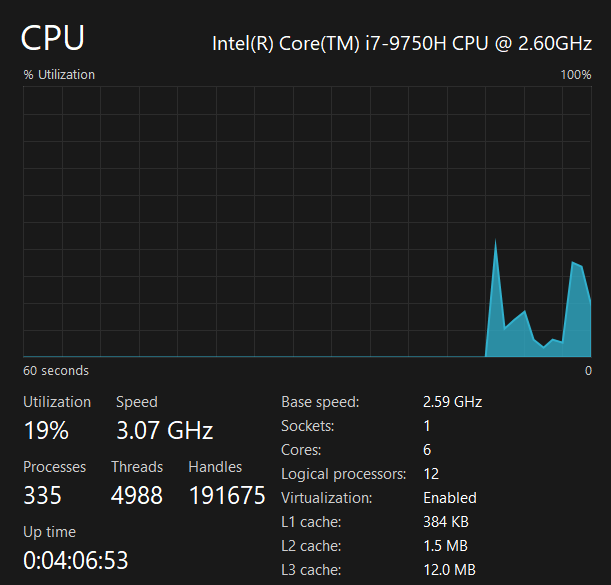

- L1 Cache Size: 384kB = 6 * 64 kB
- L2 Cache Size: 1.5 MB = 6 * 256 kB 
- L3 Cache Size: 12.0 MB

### Sharing of the caches 

As per the https://www.intel.com/content/www/us/en/products/docs/processors/core/8th-gen-core-family-datasheet-vol-1.html
> Each execution core has an instruction cache, data cache, and 256-KB L2 cache. All execution cores share the LLC (L3 cache).

- Thus each core has its own 32kB L1 instruction and 32 kB L1 data cache, 256 kB L2 cache
- The 12 MB L3 cache is shared among all the six cores

## Question 3

As per https://ark.intel.com/content/www/us/en/ark/products/191045/intel-core-i79750h-processor-12m-cache-up-to-4-50-ghz.html

- Max Memory Bandwidth: 41.8 GB/s for DDR4 onchip RAM

- Each core can execute up to two FMA (fused multiply-add) operations per cycle, assuming AVX2 instruction support.

- At a base clock speed of 2.6 GHz, this translates to a peak performance of 2 x 2 x 2.6 = 10.4 GFLOPS per core. But actual performance will be lower than theoretical peak GFLOPS per core

As per https://setiathome.berkeley.edu/cpu_list.php for i7-9750H (experimentally obtained)
- peak GFLOPS per computer (cumulative): 49.34 
- peak GFLOPS per core: = 4.11

We will use the following experimentally obtained values to compare our benchmarked performance

## Question 4

As per https://ark.intel.com/content/www/us/en/ark/products/191045/intel-core-i79750h-processor-12m-cache-up-to-4-50-ghz.html 

- Bus Speed (System Bus Frequency): 8 GT/s (Giga transfers per second) the processor uses Direct Media Interface 3.0

## Question 5

In [1]:
import time
import numpy as np
import numba
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
@numba.njit
def benchmarker(y, a, b, x):
    # performs 3 loads and 1 store
    # assuming 1 store is same as 2 loads
    # hence 5 word data traffic per iteration
    for i in range(y.shape[0]):
        y[i] = (a[i]*x[i] + b[i])


@numba.njit
def make_data(N):
    a,b,x = np.random.random((3,N))
    y = np.zeros(N)
    return a,b,x,y


def memory_bandwidth(N):
    times = []
    a, b, x, y = make_data(N)
    for _ in range(5):
        # for five times perform
        main_time = 0
        niters = 0
        while (main_time < 0.1):
            # perform as many benchmarks as possible in 0.1 seconds
            t = time.perf_counter()
            benchmarker(y, a, b, x)
            t = time.perf_counter() - t
            niters += 1
            main_time += t
        # store the time taken for niter benchmarks
        times.append((main_time, niters))
    # take the minimum time and its corresponding niters
    t = min(times)        
    # float is 8 bytes, N is array size, 5 words is data traffic
    # t[0] is the time taken and t[1] is the number of iterations
    mem_bw = (N * t[1] * 8 * 5)/t[0]
    return mem_bw

In [3]:
nvals = np.array([10, 50, 60, 70, 80, 90, 100, 500, 600, 700, 800, 900, 1000, 5000, 6000, 7000, 8000, 9000, 10000, 
                  50000, 60000, 70000, 80000, 90000, 100000, 300000, 500000, 600000, 700000, 800000, 900000, 1000000,
                  3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000,
                  10000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], dtype=np.int64)
memory_bandwidths = []

# dummy calls to warm up numba
a,b,x,y = make_data(100)
benchmarker(y,a,b,x)

# benchmarking memory bandwidth for various values of nvals
for i in tqdm(range(nvals.shape[0])):
    memory_bandwidths.append(memory_bandwidth(nvals[i]))

memory_bandwidths = np.array(memory_bandwidths)

100%|██████████| 46/46 [00:39<00:00,  1.17it/s]


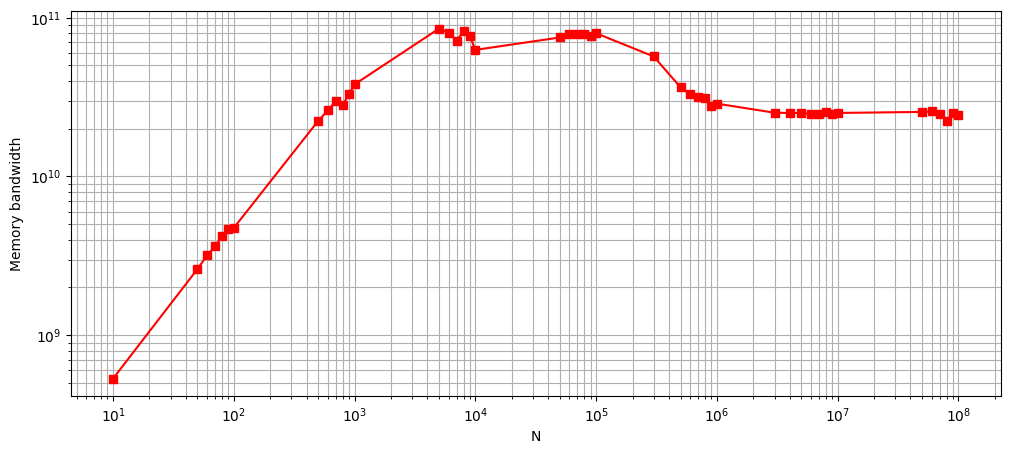

In [4]:
plt.rcParams["figure.figsize"] = (12,5)
plt.loglog(nvals, memory_bandwidths, 'rs-')
plt.xlabel("N")
plt.ylabel("Memory bandwidth")
plt.grid(True, which='both', ls='-')
plt.show()

The behavior of the plot is as was shown in the class. The bandwidth increases to reach a maximum value of close to 1 TB/s which may be for the L1 cache. Then it drops as expected to around 80-90 GB/s for individual L2 cache, 60-70 GB/s for overall L2 cache, 30-40 GB/s for L3 cache, and saturates at around 25 GB/s for the dual channel DDR4 RAM. 

Theoretically, it is expected that peak DDR4 bandwidth is 41.8 GB/s but we have obtained 25 GB/s, this may because of our architecture reaching a experimental bottleneck which doesn't allow it to reach the theoretical peak DDR4 bandwidth. 

## Question 6

In [6]:
@numba.njit
def flop_72_benchmarker(y, a, x, b):
     for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp1 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp2 = (ai*xi - bi)*(ai - bi)*(ai + bi)*(bi + xi)
        tmp3 = (ai*xi - bi)*(bi - xi)*(ai + xi)*(ai + xi)
        tmp4 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp5 = (ai*xi - bi)*(ai - bi)*(xi + bi)*(bi + xi)
        tmp6 = (ai*xi - bi)*(bi + ai)*(xi + xi)*(ai + xi)
        tmp7 = (ai*bi - xi)*(bi - xi)*(xi + ai)*(xi - bi)
        tmp8 = (ai*bi + xi)*(bi + xi)*(xi - ai)*(xi + bi)
        y[i] = ((tmp8*tmp6 + tmp7*tmp5 + bi*tmp4 - tmp3) + tmp2)*tmp1


@numba.njit
def flop_64_benchmarker(y, a, x, b):
     for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp1 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp2 = (ai*xi - bi)*(ai - bi)*(ai + bi)*(bi + xi)
        tmp3 = (ai*xi - bi)*(bi - xi)*(ai + xi)*(ai + xi)
        tmp4 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp5 = (ai*xi - bi)*(ai - bi)*(xi + bi)*(bi + xi)
        tmp6 = (ai*xi - bi)*(bi + ai)*(xi + xi)*(ai + xi)
        tmp7 = (ai*bi - xi)*(bi - xi)*(xi + ai)*(xi - bi)
        y[i] = ((ai*tmp6 + tmp7*tmp5 + bi*tmp4 - tmp3) + tmp2)*tmp1


@numba.njit
def flop_32_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp1 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp2 = (ai*xi - bi)*(ai - bi)*(ai + bi)*(bi + xi)
        tmp3 = (ai*xi - bi)*(bi - xi)*(ai + xi)*(ai + xi)
        y[i] = ((ai*ai + xi*xi + bi*bi - tmp3) + tmp2)*tmp1


@numba.njit
def flop_24_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp1 = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        tmp2 = (ai*xi - bi)*(ai - bi)*(ai + bi)*(bi + xi)
        y[i] = ((ai*ai + xi*xi + bi*bi - tmp1) + tmp2)*tmp1


@numba.njit
def flop_16_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        tmp = (ai*xi + bi)*(ai + bi)*(ai - bi)*(bi - xi)
        y[i] = ((ai*ai + xi*xi + bi*bi - tmp) + tmp)*tmp


@numba.njit
def flop_4_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        y[i] = (((a[i] + b[i])*x[i]) + b[i])*a[i]


@numba.njit
def flop_8_benchmarker(y, a, b, x):
    for i in range(y.shape[0]):
        ai = a[i]
        bi = b[i]
        xi = x[i]
        y[i] = ((ai*ai + xi*xi + bi*bi - 3.14) + 3.14)*3.14


def flops(N, k, benchmarker):
    times = []
    a, b, x, y = make_data(N)
    for _ in range(5):
        main_time = 0
        niters = 0
        while (main_time < 0.1):
            t = time.perf_counter()
            benchmarker(y, a, b, x)
            t = time.perf_counter() - t
            niters += 1
            main_time += t
        times.append((main_time, niters))
    t = min(times)        
    flops = (N * t[1] * k)/t[0]
    return flops

In [7]:
nvals = np.array([10, 50, 60, 70, 80, 90, 100, 500, 600, 700, 800, 900, 1000, 5000, 6000, 7000, 8000, 9000, 10000, 
                  50000, 60000, 70000, 80000, 90000, 100000, 300000, 500000, 600000, 700000, 800000, 900000, 1000000,
                  3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000,
                  10000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], dtype=np.int64)

flops_72 = []
flops_64 = []
flops_32 = []
flops_24 = []
flops_16 = []
flops_8 = []
flops_4 = []

# dummy calls to warm up numba
a,b,x,y = make_data(100)
flop_72_benchmarker(y, a, x, b)
flop_64_benchmarker(y, a, x, b)
flop_32_benchmarker(y, a, x, b)
flop_24_benchmarker(y, a, x, b)
flop_16_benchmarker(y, a, x, b)
flop_8_benchmarker(y, a, x, b)
flop_4_benchmarker(y, a, x, b)


# benchmarking performance for different values of array size for 72 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_72.append(flops(nvals[i], 72, flop_72_benchmarker))

# benchmarking performance for different values of array size for 64 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_64.append(flops(nvals[i], 64, flop_64_benchmarker))

# benchmarking performance for different values of array size for 32 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_32.append(flops(nvals[i], 32, flop_32_benchmarker))

# benchmarking performance for different values of array size for 24 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_24.append(flops(nvals[i], 24, flop_24_benchmarker))

# benchmarking performance for different values of array size for 16 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_16.append(flops(nvals[i], 16, flop_16_benchmarker))

# benchmarking performance for different values of array size for 8 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_8.append(flops(nvals[i], 8, flop_8_benchmarker))

# benchmarking performance for different values of array size for 4 flops code
for i in tqdm(range(nvals.shape[0])):
    flops_4.append(flops(nvals[i], 4, flop_4_benchmarker))

flops_72 = np.array(flops_72)
flops_64 = np.array(flops_64)
flops_32 = np.array(flops_32)
flops_24 = np.array(flops_24)
flops_16 = np.array(flops_16)
flops_8 = np.array(flops_8)
flops_4 = np.array(flops_4)

100%|██████████| 46/46 [00:39<00:00,  1.16it/s]


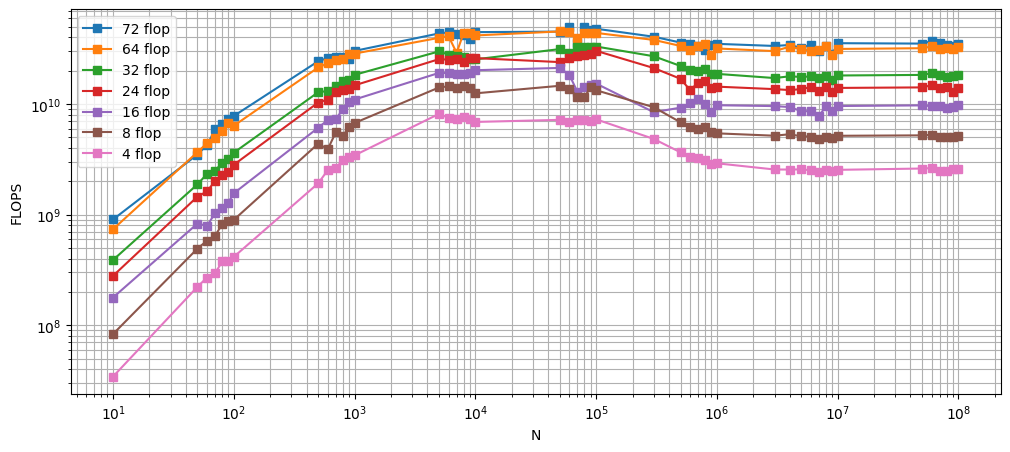

In [9]:
plt.rcParams["figure.figsize"] = (12,5)
plt.loglog(nvals, flops_72, 's-', label='72 flop')
plt.loglog(nvals, flops_64, 's-', label='64 flop')
plt.loglog(nvals, flops_32, 's-', label='32 flop')
plt.loglog(nvals, flops_24, 's-', label='24 flop')
plt.loglog(nvals, flops_16, 's-', label='16 flop')
plt.loglog(nvals, flops_8, 's-', label='8 flop')
plt.loglog(nvals, flops_4, 's-', label='4 flop')
plt.xlabel("N")
plt.ylabel("FLOPS")
plt.legend()
plt.grid(True, which='both', ls='-')
plt.show()

The nature of the plot is similar to the Memory Bandwidth plot from earlier and increases, decreases and saturates for large input size. As we increase the number of floating point operations done per operation, the effects of pipelining and superscalar are evident and the overall FLOPS increases and tend to saturate as we go above 64 FLOPS/iteration after which we are bound by computing power, when the plot saturates. The maxima of each plot can be seen below as follows

In [10]:
print("Max GFLOPS for 72 FLOP benchmark code", max(flops_72)/1e9)
print("Max GFLOPS for 64 FLOP benchmark code", max(flops_64)/1e9)
print("Max GFLOPS for 32 FLOP benchmark code", max(flops_32)/1e9)
print("Max GFLOPS for 24 FLOP benchmark code", max(flops_24)/1e9)
print("Max GFLOPS for 16 FLOP benchmark code", max(flops_16)/1e9)
print("Max GFLOPS for 8 FLOP benchmark code", max(flops_8)/1e9)
print("Max GFLOPS for 4 FLOP benchmark code", max(flops_4)/1e9)

Max GFLOPS for 72 FLOP benchmark code 50.104484325535964
Max GFLOPS for 64 FLOP benchmark code 45.31127503451943
Max GFLOPS for 32 FLOP benchmark code 33.114403665813434
Max GFLOPS for 24 FLOP benchmark code 30.263606579917468
Max GFLOPS for 16 FLOP benchmark code 21.199406412794712
Max GFLOPS for 8 FLOP benchmark code 14.61850890866153
Max GFLOPS for 4 FLOP benchmark code 8.145734810036641


Thus we see that the cumulative GFLOPS for our benchmark is 50.10 GFLOPS, which is about the same order as suggested by the experimental reference which said 49.34 GFLOPS.